In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch    


import sys
sys.path.append('..')

# reload in jupyter
%load_ext autoreload
%autoreload 2

from mix_NCA.utils_simulations import grid_to_channels_batch, train_nca_dyn, plot_nca_prediction, classification_update_net, plot_nca_prediction2, plot_automata_comparison_grid
from mix_NCA.NCA import NCA 
from mix_NCA.MixtureNCA import MixtureNCA
from mix_NCA.TissueModel import ComplexCellType, TissueModel, create_simple_model_example, plot_cell_type_evolution
from mix_NCA.MixtureNCANoise import MixtureNCANoise


# seet seed
np.random.seed(42)


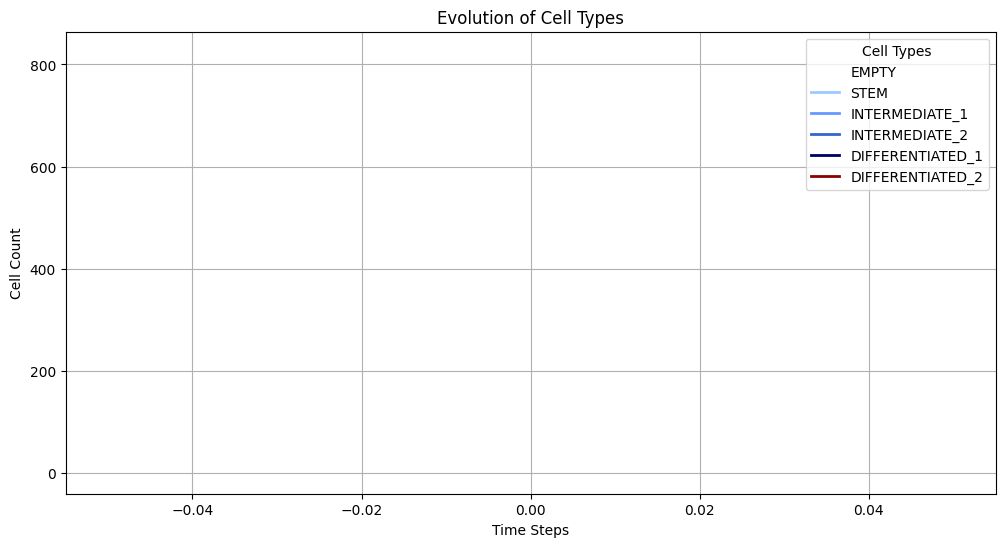

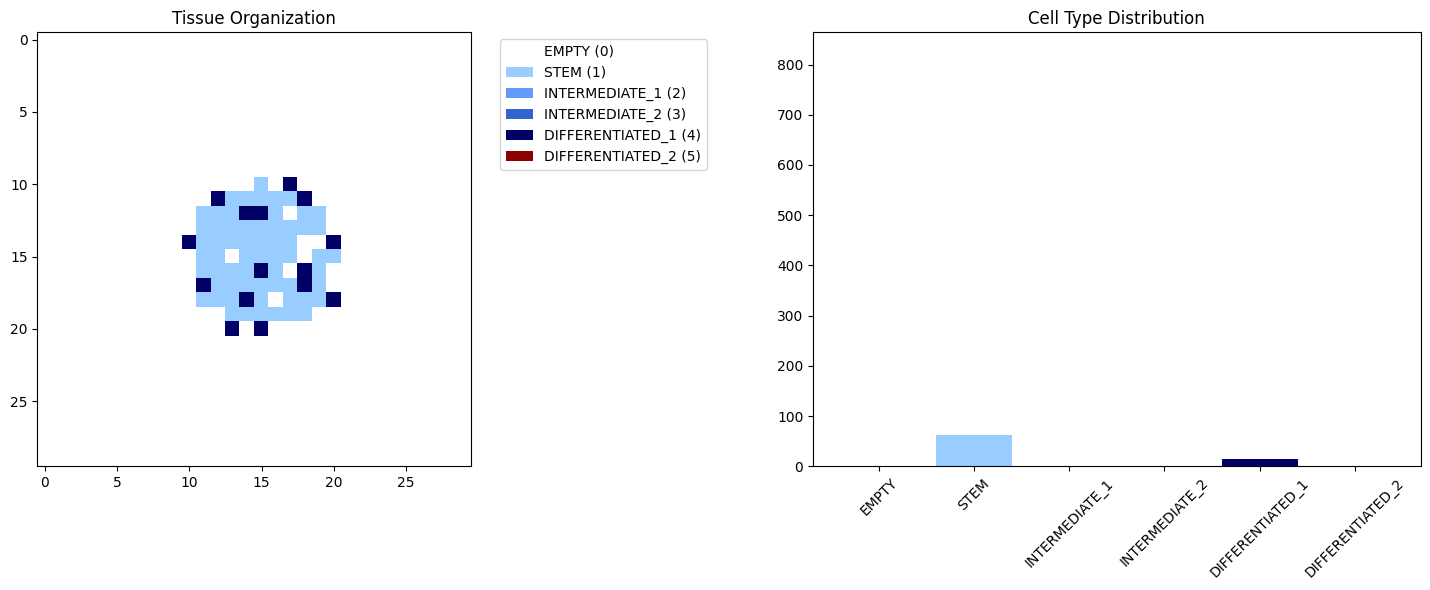

In [2]:
# Create and run model
model = create_simple_model_example(30)

# Run simulation
steps = 1
history = []
for _ in range(steps):
    model.step()
    history.append(model.grid.copy())

# Plot results
plot_cell_type_evolution(history)

# Plot final state
model.plot_tissue(show_statistics=True)

In [3]:
NSTEPS = 10
N_SIMULATIONS = 200
histories = []
spatial_models = []
for i in range(N_SIMULATIONS):
    n_stems = np.random.randint(25, high=26)
    model = create_simple_model_example(n_stems)
    history, _ = model.simulate(NSTEPS)
    histories.append(history)
    spatial_models.append(model)

In [44]:
# save histories
torch.save(histories, "histories_prova_noise.pth")

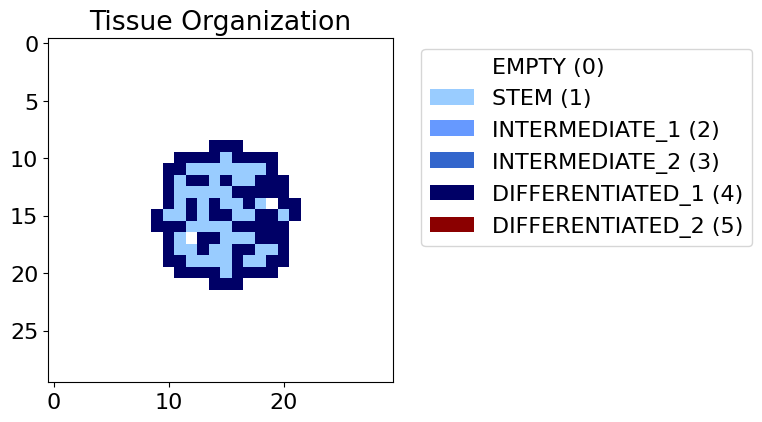

In [4]:
# change size of the plot and font size
plt.rcParams['figure.figsize'] = [30, 12]
plt.rcParams['font.size'] = 16

spatial_models[30].plot_tissue(show_statistics=False)

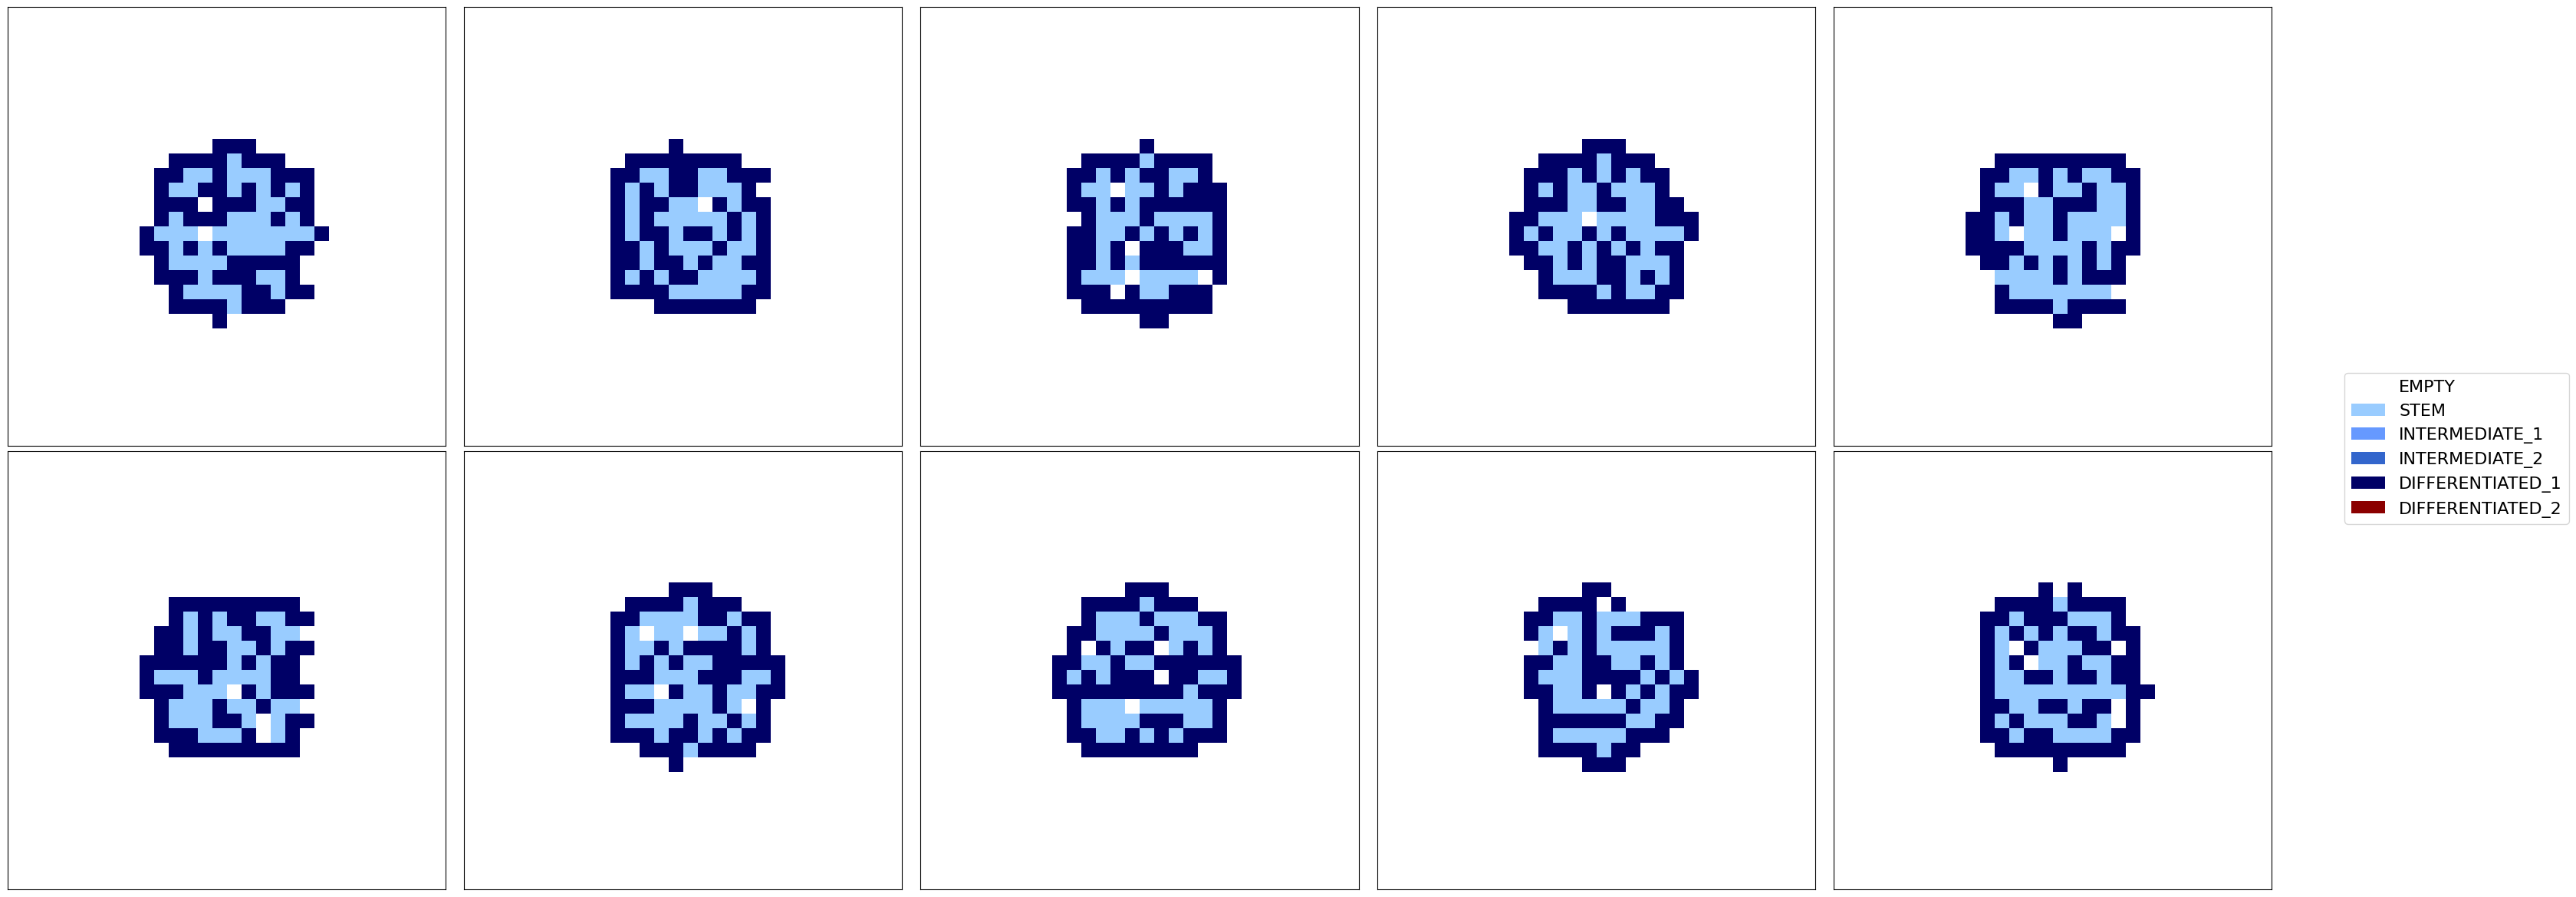

In [5]:
# Create a figure with 2 rows and 6 columns
fig, axes = plt.subplots(2, 5, figsize=(30, 12))

# Get colors from ComplexCellType enum via TissueModel
colors = [cell_type.get_color() for cell_type in ComplexCellType]
cmap = plt.cm.colors.ListedColormap(colors)

# Plot models in grid 
for i in range(2):
    for j in range(5):
        model_idx = i*5 + j
        ax = axes[i,j]
        grid = spatial_models[model_idx].grid
        im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=len(ComplexCellType)-1)
        ax.set_xticks([])
        ax.set_yticks([])

# Add a common colorbar
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=cell_type.get_color(), label=f"{cell_type.name}")
    for cell_type in ComplexCellType
]
fig.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.5), loc='center left')
        
plt.tight_layout()



In [6]:
mix_nca = MixtureNCA(update_nets = classification_update_net, hidden_dim = 64, 
                     maintain_seed = False, use_alive_mask = False, state_dim = 6, 
                     num_rules = 2, residual = False, device = "cuda:1", temperature=1)

In [7]:
torch.manual_seed(6)
train_nca_dyn(model=mix_nca, target_states=histories,n_cell_types = 6, n_epochs=1000, time_length = 11, 
              update_every = 1, device = "cuda:1",
               temperature = 3, min_temperature = 0.1, anneal_rate = 0.005, lr = 0.001, milestones = [200, 600], gamma = 0.9)

Precomputing grid representations...


Training NCA (mse): 100%|██████████| 1000/1000 [00:48<00:00, 20.50it/s, loss=0.002074, window=0-11]


0.022819412173703313

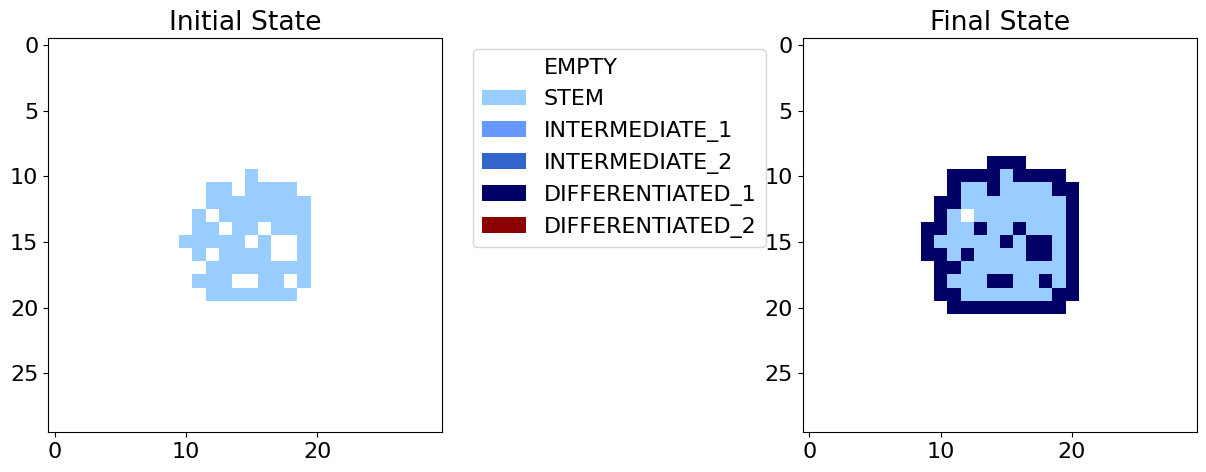

In [8]:
plot_nca_prediction(mix_nca, histories[10][0],steps = 10,n_cell_types = 6,
                     cell_type_enum = ComplexCellType , 
                    show_intermediate = False, random = True, random_seed = 3)

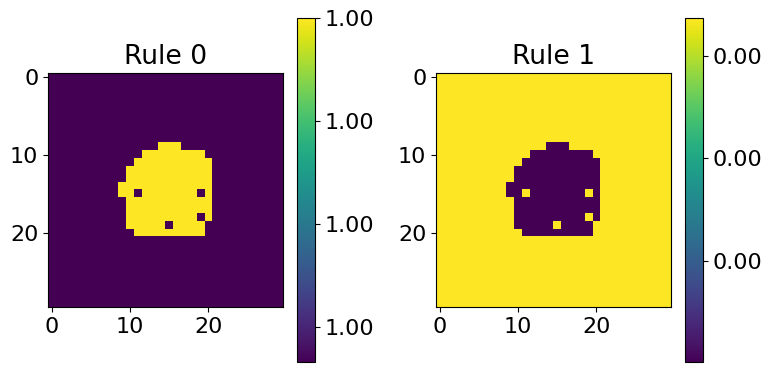

In [9]:
x = grid_to_channels_batch(grids=histories[10], n_cell_types=6, device = "cuda:1")
mix_nca.to("cuda:1")
_ = mix_nca.visualize_rule_assignments(x[9:].to("cuda:1"))

In [10]:
torch.save(mix_nca.state_dict(), "mix_nca_prova_noise.pth")


In [11]:
stochastic_mix_nca = MixtureNCANoise(update_nets = classification_update_net, hidden_dim = 64,
                                      maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = 2, 
                                     residual = False, device = "cuda:3", temperature=1)



In [ ]:
train_nca_dyn(model=stochastic_mix_nca, target_states=histories,n_cell_types = 6, n_epochs=800,
               time_length = 11, update_every = 1, device = "cuda:3", lr = 0.0001, milestones = [1000],
               temperature = 3, min_temperature = 0.1, anneal_rate = 0.005, straight_through=False)

Precomputing grid representations...


Training NCA (mse):  75%|███████▌  | 679/900 [00:35<00:11, 19.22it/s, loss=0.002576, window=0-11]


KeyboardInterrupt: 

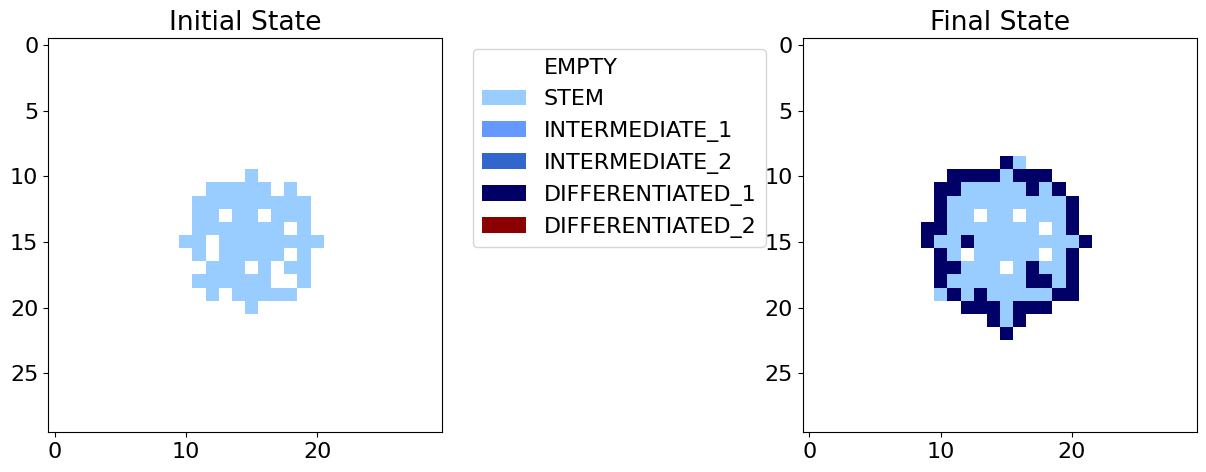

In [70]:
plot_nca_prediction(stochastic_mix_nca, histories[5][0],steps = 11,n_cell_types = 6,
                    cell_type_enum = ComplexCellType , show_intermediate = False, random = True,
                    random_seed = 3, device = "cuda:3")

In [71]:
# save the model
torch.save(stochastic_mix_nca.state_dict(), "stochastic_mix_nca_prova_noise.pth")


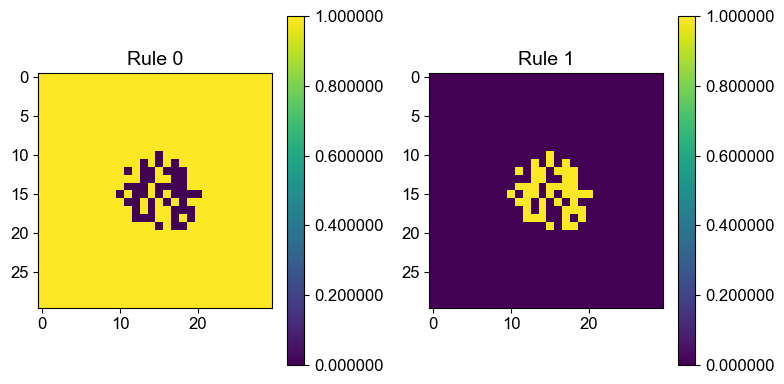

In [35]:
x = grid_to_channels_batch(grids=histories[3], n_cell_types=6, device = "cuda:3")
_ = stochastic_mix_nca.visualize_rule_assignments(x[10:])

In [36]:
inital_state = x[4].unsqueeze(0)
num_trials = 5000
num_steps = 1

stochastic_mix_nca.save_internal_noise = True

all_outputs = []
noise_outputs = []
for i in range(num_trials):
    torch.manual_seed(i)
    with torch.no_grad():
        outputs = stochastic_mix_nca(inital_state.clone(), num_steps, return_history=False, sample_non_differentiable=True)

        all_outputs.append(outputs.cpu().numpy())
        noise_outputs.append(stochastic_mix_nca.internal_noise.cpu().numpy())
all_outputs = np.array(all_outputs)  # [num_trials, num_steps, batch, channels, height, width]
noise_outputs = np.array(noise_outputs)  # [num_trials, num_steps, batch, channels, height, width]

In [37]:
noise_values = noise_outputs.squeeze()
noise_values[noise_values == 0] = -np.inf
noise_values = np.max(noise_values, axis = 1)

# get the point with the highest change in the update
points = np.unravel_index(np.argmax(np.std(np.argmax(all_outputs.squeeze(1), axis = 1), axis = 0)), all_outputs.squeeze(1)[:,0, 0].shape)

# Get points ordered by highest change in update
points_by_update = np.argsort(np.std(np.argmax(all_outputs.squeeze(1), axis=1), axis=0).flatten())[::-1]
points_by_update = np.unravel_index(points_by_update, all_outputs.squeeze(1)[:,0, 0].shape)
points_by_update = np.column_stack((points_by_update[0], points_by_update[1]))





/tmp/ipykernel_2790153/263825637.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  plt.scatter(noise_values[:,points[0],points[1]].flatten(), all_outputs.squeeze(1)[:,0, points[0], points[1]].flatten(),  cmap='viridis', norm=plt.cm.colors.LogNorm())


Text(0.5, 1.0, '2D Histogram of Noise vs Update')

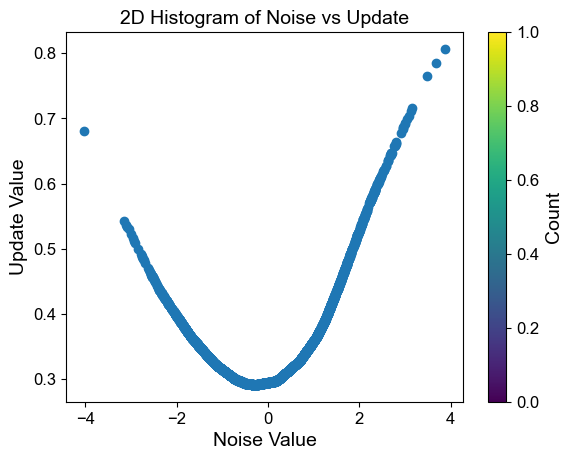

In [38]:
# Create 2D histogram
plt.scatter(noise_values[:,points[0],points[1]].flatten(), all_outputs.squeeze(1)[:,0, points[0], points[1]].flatten(),  cmap='viridis', norm=plt.cm.colors.LogNorm())
# plot 
plt.colorbar(label='Count')
plt.xlabel('Noise Value')
plt.ylabel('Update Value')
plt.title('2D Histogram of Noise vs Update')

In [39]:
np.unique(np.argmax(all_outputs.squeeze(1)[:,:, points[0], points[1]], axis=1).flatten())

array([0, 4])

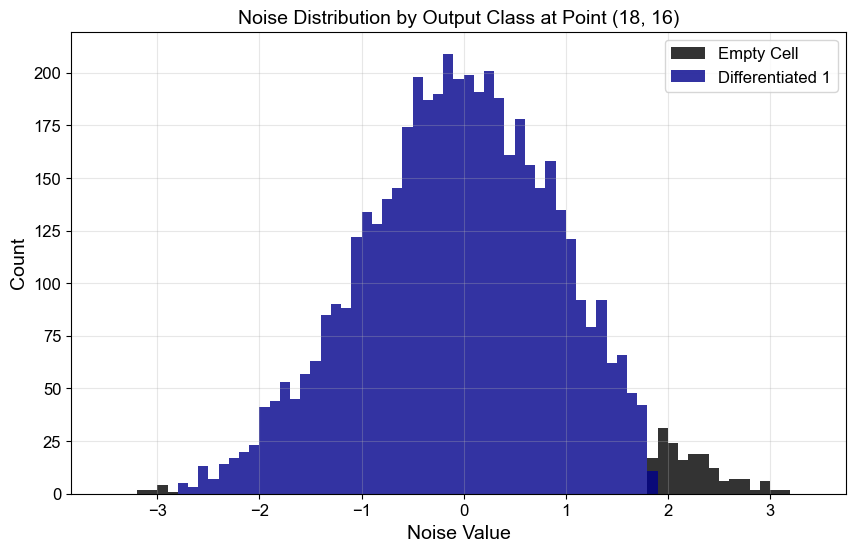

In [40]:
# Flatten the noise values and get output classes
flat_noise = noise_values[:,points[0],points[1]].flatten()
output_classes = np.argmax(all_outputs.squeeze(1)[:,:, points[0], points[1]], axis=1).flatten()

labels = {0 : "Empty Cell", 4 : "Differentiated 1", 1 : "Stem", 5 : "Differentiated 2"}
colors = {0 : "black", 4 : "darkblue", 1 : "darkblue", 5 : "darkred"}

# Create histogram
plt.figure(figsize=(10, 6))
for cls in np.unique(output_classes):
    mask = output_classes == cls
    # get the poptimal number of bins using numpy
    plt.hist(flat_noise[mask], bins=np.arange(-3.5, 3.5 , 0.1), alpha=0.8, label=labels[cls], color = colors[cls])

plt.xlabel('Noise Value')
plt.ylabel('Count')
plt.title(f'Noise Distribution by Output Class at Point ({points[0]}, {points[1]})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [41]:
6 / 1000

0.006

183
4817
41
4959


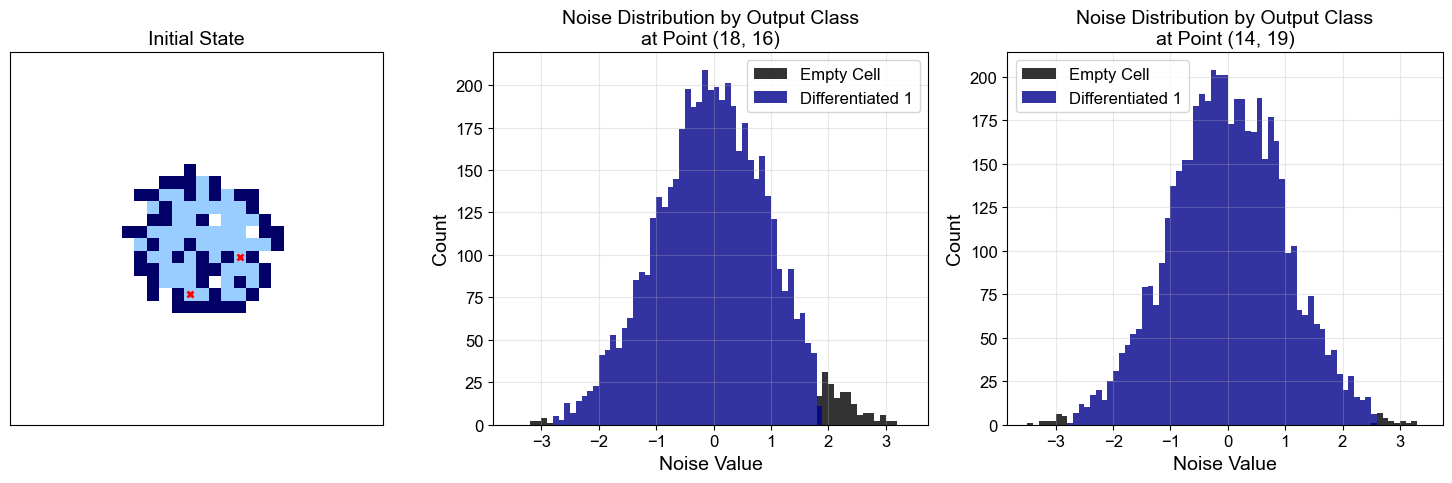

In [48]:
# Recreate the figure shown: initial state on the left, two histograms on the right, with red crosses on the two points


from mix_NCA.TissueModel import ComplexCellType

cell_type_enum = ComplexCellType

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
pt1 = points_by_update[0]
pt2 = points_by_update[1]
# 1. Initial State plot (left)
# Assuming 'init_state' is a 2D numpy array representing the initial state
# and that 0=Empty, 1=Stem, 4/5=Differentiated
colors = [cell_type.get_color() for cell_type in cell_type_enum]
cmap = plt.cm.colors.ListedColormap(colors)
im = axes[0].imshow(x[4].argmax(dim=0).cpu().numpy(), cmap=cmap, interpolation='none', vmin=0, vmax=len(cell_type_enum)-1)
axes[0].set_title('Initial State')
# Mark the two points with red crosses
axes[0].plot(pt1[0], pt1[1], 'rx', markersize=5, markeredgewidth=2)  # (col, row)
axes[0].plot(pt2[0], pt2[1], 'rx', markersize=5, markeredgewidth=2)
axes[0].set_xticks([])
axes[0].set_yticks([])

# 2. Histogram for point (14, 13)
flat_noise1 = noise_values[:, pt1[0], pt1[1]].flatten()
output_classes1 = np.argmax(all_outputs.squeeze(1)[:, :, pt1[0], pt1[1]], axis=1).flatten()
labels = {0: "Empty Cell", 4: "Differentiated 1"}
colors = {0: "black", 4: "darkblue"}

for cls in [0,4]:
    mask = output_classes1 == cls
    print(np.sum(mask))
    axes[1].hist(flat_noise1[mask], bins=np.arange(-3.5, 3.5, 0.1), alpha=0.8, label=labels.get(cls, str(cls)), color=colors.get(cls, 'gray'))
axes[1].set_xlabel('Noise Value')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Noise Distribution by Output Class\nat Point ({pt1[0]}, {pt1[1]})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Histogram for point (14, 17)
flat_noise2 = noise_values[:, pt2[0], pt2[1]].flatten()
output_classes2 = np.argmax(all_outputs.squeeze(1)[:, :, pt2[0], pt2[1]], axis=1).flatten()
for cls in [0,4]:
    mask = output_classes2 == cls
    print(np.sum(mask))
    axes[2].hist(flat_noise2[mask], bins=np.arange(-3.5, 3.5, 0.1), alpha=0.8, label=labels.get(cls, str(cls)), color=colors.get(cls, 'gray'))
axes[2].set_xlabel('Noise Value')
axes[2].set_ylabel('Count')
axes[2].set_title(f'Noise Distribution by Output Class\nat Point ({pt2[0]}, {pt2[1]})')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

#save the figure
plt.savefig("../figures/" + "mix_nca_prova_noise_hist.png", dpi=300, bbox_inches='tight')

plt.show()



/tmp/ipykernel_2790153/1622029034.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mix_nca.load_state_dict(torch.load("mix_nca_prova_noise.pth"))
/tmp/ipykernel_2790153/

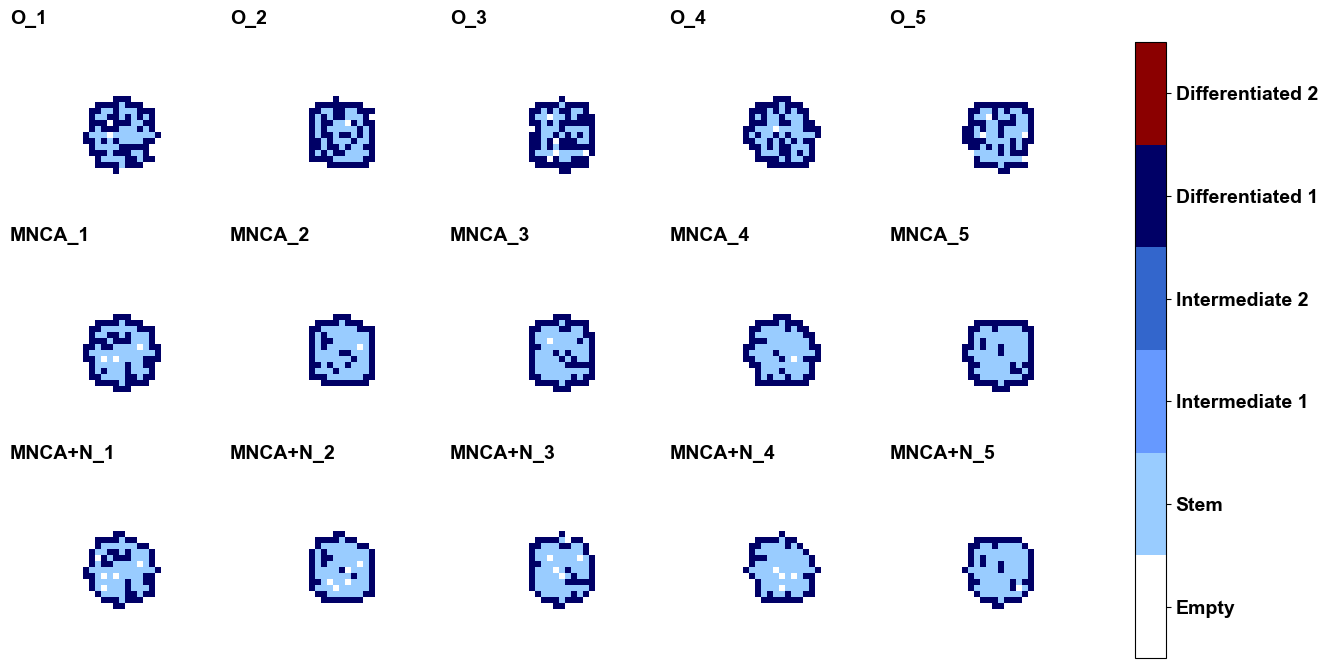

In [49]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

    # Now 5 rows: Original, NCA, GCA, MNCA, MNCA+N
fig, axes = plt.subplots(3, 5, figsize=(15, 8))


cell_type_enum = ComplexCellType

colors = [cell_type.get_color() for cell_type in cell_type_enum]
custom_cmap = mcolors.ListedColormap(colors)


mix_nca.load_state_dict(torch.load("mix_nca_prova_noise.pth"))
stochastic_mix_nca.load_state_dict(torch.load("stochastic_mix_nca_prova_noise.pth"))

mix_nca.eval()
stochastic_mix_nca.eval()

stochastic_mix_nca.temperature = 0.1
mix_nca.temperature = 0.1

models = {
    0: ('Original', None),
    1: ('MNCA', mix_nca.to("cuda:3")),
    2: ('MNCA+N', stochastic_mix_nca.to("cuda:3"))
}

model_abbreviations = {
    0: 'O',
    1: 'MNCA',
    2: 'MNCA+N'
}

for row in range(3):
    model_name, model = models[row]
    for col in range(5):
        ax = axes[row, col]
        label = f'{model_abbreviations[row]}_{col + 1}'
        ax.text(-0.1, 1.1, label, transform=ax.transAxes, 
                fontsize=14, fontweight='bold')
        if row == 0:
            # Plot original state
            ax.imshow(
                histories[col][-1],
                cmap=custom_cmap,
                vmin=0,
                vmax=len(cell_type_enum)-1
            )
            if col == 0:
                ax.set_ylabel(model_name, fontsize=14, fontweight='bold')
        else:
            with torch.no_grad():
                torch.manual_seed(col)
                current_state = grid_to_channels_batch([histories[col][0]], n_cell_types = len(cell_type_enum), device = "cuda:3")
                for _ in range(11):
                    if row in [1,2]:
                        current_state = models[row][1](current_state, 1, return_history=False, sample_non_differentiable = True)
                    else:
                        current_state = models[row][1](current_state, 1, return_history=False)
                    ax.imshow(
                        torch.argmax(current_state.squeeze(), dim=0).cpu(),
                        cmap=custom_cmap,
                        vmin=0,
                        vmax=len(cell_type_enum)-1
                    )
                if col == 0:
                    ax.set_ylabel(model_name, fontsize=14, fontweight='bold')
        ax.axis('off')

norm = plt.Normalize(vmin=-0.5, vmax=len(cell_type_enum)-0.5)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_ticks(range(len(cell_type_enum)))
cbar.set_ticklabels([ct.name.replace('_', ' ').title() for ct in cell_type_enum])
cbar.ax.tick_params(labelsize=14)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')
cbar.set_label('', fontsize=14, fontweight='bold')
# save the figure
plt.savefig("../figures/" + "mix_nca_prova_noise_comparison.png", dpi=300, bbox_inches='tight')